## Design verification example using Jupyter

Simple idea to stimulate new workflows for analog design, since design verif tends to be very tedious using UI-based EDA tools.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import Image

from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

## Create .spiceinit (ngspice)

In [2]:
%%writefile .spiceinit
set ngbehavior=hsa
set ng_nomodcheck

Overwriting .spiceinit


## DUT definitions

In [3]:
maindir  = os.getcwd()
celldir  = '../xschem'
cellname = 'inverter'

## Export and show DUT schematic

In [4]:
!cd $celldir && xschem $cellname\.sch -p --png --plotfile $cellname\.png -q -l xschem.log && cd $maindir

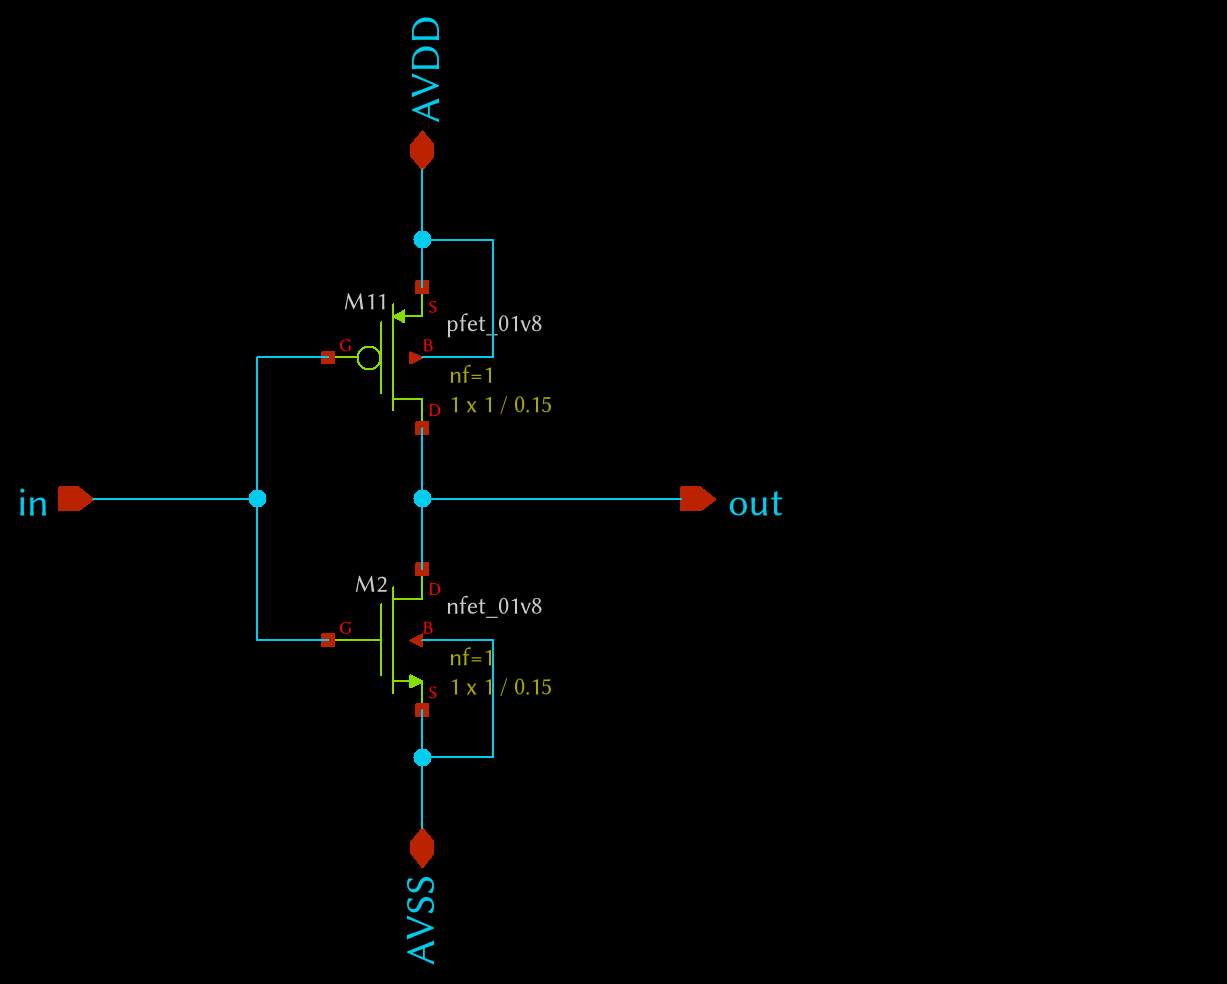

In [5]:
Image('{}/{}.png'.format(celldir, cellname))

## Export DUT netlist

In [6]:
!xschem -n $celldir/$cellname.sch -x -q -l xschem.log
!sed -i '/\.subckt/ s/\*\*//g;/\.end/ s/\*\*//g; s/\.end\b//g' $celldir/$cellname\.spice
!head $celldir/$cellname\.spice -n 8


** sch_path: /home/vpreuss/repos/sky130-analog-playground/xschem/inverter.sch
.subckt inverter out in AVSS AVDD
*.opin out
*.ipin in
*.iopin AVSS
*.iopin AVDD
XM11 out in AVDD AVDD sky130_fd_pr__pfet_01v8 L=0.15 W=1 nf=1 ad='int((nf+1)/2) * W/nf * 0.29' as='int((nf+2)/2) * W/nf * 0.29'
+ pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)' nrd='0.29 / W' nrs='0.29 / W'


## Create testbench file

In [7]:
%%writetemplate {cellname}_tb.spice

.lib ~/repos/pdks/sky130/sky130A/libs.tech/ngspice/sky130.lib.spice tt_mm
.include {celldir}/{cellname}.spice

v1 avdd 0 1.8
v2 vin 0 dc 0 pulse (0 2 95n 2n 2n 90n 180n)
xdut vout vin 0 avdd {cellname}
cload vout 0 1e-12

.control
save all
dc v2 0 1.8 0.01
display
wrdata output.txt v(vout)
.endc

## Run testbench

In [8]:
!ngspice -b $cellname\_tb.spice


Note: Compatibility modes selected: hs a



Circuit: 

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

 Reference value :  0.00000e+00
No. of Data Rows : 181
Here are the vectors currently active:

Title: 
Name: dc1 (DC transfer characteristic)
Date: Fri Jan  6 19:10:36  2023

    avdd                : voltage, real, 181 long
    m.xdut.xm11.msky130_fd_pr__pfet_01v8#body: voltage, real, 181 long
    m.xdut.xm11.msky130_fd_pr__pfet_01v8#dbody: voltage, real, 181 long
    m.xdut.xm11.msky130_fd_pr__pfet_01v8#sbody: voltage, real, 181 long
    m.xdut.xm2.msky130_fd_pr__nfet_01v8#body: voltage, real, 181 long
    m.xdut.xm2.msky130_fd_pr__nfet_01v8#dbody: voltage, real, 181 long
    m.xdut.xm2.msky130_fd_pr__nfet_01v8#sbody: voltage, real, 181 long
    v-sweep             : voltage, real, 181 long [default scale]
    v1#branch           : current, real, 181 long
    v2#branch           : current, real, 181 long

## Plot results

In [9]:
df = pd.read_csv("output.txt", delim_whitespace=True, header=None)
df.columns = ["vin", "vout"]
df

,vin,vout
0,0.00,1.800000e+00
1,0.01,1.800000e+00
2,0.02,1.800000e+00
3,0.03,1.800000e+00
4,0.04,1.800000e+00
...,...,...
176,1.76,3.262560e-07
177,1.77,2.724032e-07
178,1.78,2.266574e-07
179,1.79,1.879282e-07


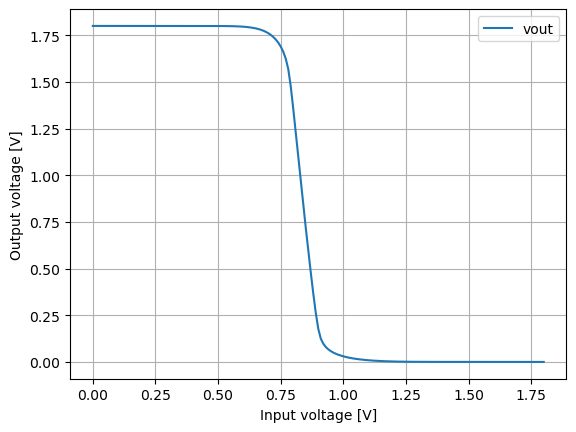

In [10]:
df.plot(x="vin", y="vout")
plt.xlabel('Input voltage [V]')
plt.ylabel('Output voltage [V]')
plt.grid()
plt.show()